# Lindblad Simulation

In this guide you will learn how to create a simulation of the
Lindblad equation, which is given by
$$
\newcommand{\iu}{\mathrm{i}}
        \iu \hbar \dot\rho(t) = \hat{\mathcal{L}}\rho(t) \,,
$$
where $\hat{\mathcal{L}}$ is the *Lindbladian* with
$$
\newcommand{\iu}{\mathrm{i}}
\begin{aligned}
  \hat{\mathcal{L}}\rho
    = [\hat{H}, \rho]
    &+
    \iu \hbar \sum_{i=0}^{M-1} \sum_{j=0}^{M-1} \gamma_{ij}^z
    \big(
        \hat{S}^z_i \rho \hat{S}^z_j 
        - \tfrac12 \hat{S}^z_j \hat{S}^z_i \rho
        - \tfrac12 \rho \hat{S}^z_j \hat{S}^z_i
    \big) \\\    &+
    \iu \hbar \sum_{i=0}^{M-1} \sum_{j=0}^{M-1} \gamma_{ij}^+
    \big(
        \hat{S}^+_i \rho \hat{S}^-_j
        - \tfrac12 \hat{S}^-_j \hat{S}^+_i \rho
        - \tfrac12 \rho \hat{S}^-_j \hat{S}^+_i
    \big) \\\    &+
    \iu \hbar \sum_{i=0}^{M-1} \sum_{j=0}^{M-1} \gamma_{ij}^-
    \big(
        \hat{S}^-_i \rho \hat{S}^+_j
        - \tfrac12 \hat{S}^+_j \hat{S}^-_i \rho
        - \tfrac12 \rho \hat{S}^+_j \hat{S}^-_i
    \big)
    \,.
\end{aligned}
$$
Here, $\hat{H}$ is a Hamiltonian of a spin system. For this guide, we
choose the Hamiltonian of the Heisenberg spin chain, i.e.,
$$
  \hat{H} = J \sum_{j=0}^{M-2}
    \hat{\mathbf{S}}_j \cdot \hat{\mathbf{S}}_{j+1}
  \,.
$$

## Imports and Parameters

Throughout this guide, we will make use of the following imports.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random
from matplotlib import animation
from scipy.linalg import toeplitz

from hqs_quantum_solver.spins import (
    VectorSpace, Operator, SpinState, isotropic_interaction)
from hqs_quantum_solver.util import unit_vector
from hqs_quantum_solver.lindblad import Lindbladian
from hqs_quantum_solver.evolution import evolve_krylov, observers

# License check turned off for lattice_functions.
# License check turned off for lattice_solver.


Furthermore, we make use of the parameters as shown below.

In [2]:
n_spins = 6  # The number of spins.
t_end = 10   # The duration of the simulation.
J = 1        # The interaction strength.

## Hamiltonian and Lindblad

To construct the Lindbladian, we first have to define the vector space that
we are using, then construct the Hamiltonian, and then combine the two to
obtain the Lindblad operator. We start with the vector space.

The vector space is defined by creating a
[VectorSpace](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.spins.html#hqs_quantum_solver.spins.VectorSpace) object from the
[spins](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.spins.html) module.
The vector spaces we use in quantum mechanics are defined by the
states they represent. Thus, to construct the
[VectorSpace](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.spins.html#hqs_quantum_solver.spins.VectorSpace) object, we have to describe
the states of the system. First, we give the `sites` argument to
specify the number of spins in the system. Second, we give the
`total_spin_z` argument, which can be used to only include the states with
a given total spin polarization. Since we do not want to restrict the
total spin, we provide `"all"` as an argument.

In [3]:
v = VectorSpace(sites=n_spins, total_spin_z="all")

To construct a spin operator in HQS Quantum Solver, we need to pass an
expression that describes the operator to the constructor of the
[Operator](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.spins.html#hqs_quantum_solver.spins.Operator) class.
We use the
[isotropic_interaction](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.spins.html#hqs_quantum_solver.spins.isotropic_interaction) function to
obtain the desired expression. This function takes a matrix, where the
entry at index $(j, k)$ determines the interaction strength of site $j$ to
site $k$ and vice versa.
By providing a matrix where the first upper off-diagonal is set to a
constant value and the remaining entries set to zero, we obtain the
desired spin chain model.

In [4]:
coef = J * toeplitz(np.zeros(v.sites), unit_vector(v.sites, 1))
H = Operator(isotropic_interaction(coef), domain=v, dtype=complex)

Next, we need to set up the coefficient matrices $\gamma^z$, $\gamma^+$,
and $\gamma^-$. For this example, we choose these matrices as random,
positive definite matrices.
Once the matrices are constructed, we pass them together with the
Hamiltonian to the constructor of the
[Lindbladian](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.lindblad.html#hqs_quantum_solver.lindblad.Lindbladian) class, giving us the
desired Lindblad operator.

In [5]:
rng = numpy.random.default_rng(1234)

def random_positive_definite(low, high, shape):
    r = rng.uniform(low, high, shape)
    return r.T.conj() @ r

gamma_z = random_positive_definite(0, 0.3, (v.sites, v.sites))
gamma_p = random_positive_definite(0, 0.2, (v.sites, v.sites))
gamma_m = random_positive_definite(0, 0.1, (v.sites, v.sites))

L = Lindbladian(H, gamma_z, gamma_p, gamma_m)

## Initial State

Before we can simulate the time evolution, we need to define the
initial state of the simulation. We choose
$\rho = \psi \psi^\dagger$ where
$\psi = \ket{ \uparrow \downarrow \downarrow \cdots \downarrow }$.
The vector $\psi$ is constructed by calling the
[fock_state](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.spins.html#hqs_quantum_solver.spins.VectorSpace.fock_state) function with
a list containing `SpinState.UP` followed by multiple `SpinState.DOWN`
entries.

In [6]:
state = v.fock_state([SpinState.UP] + [SpinState.DOWN] * (n_spins-1))
rho = state[:,np.newaxis] @ state[:,np.newaxis].T.conj()

## Time Evolution

We can finally perform the actual time evolution of the system.
The form of the Lindblad equation listed at the beginning is compatible
with the regular time-stepping functions provided by Quantum Solver.
Here, we want to use the
[evolve_krylov](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.evolution.html#hqs_quantum_solver.evolution.evolve_krylov) function.
We provide the operator, the initial state, and a list of time points at
which to evaluate the state of the system. Note, that internally a
step-size is chosen that guarantees the desired accuracy. The time points
are only used for the evaluation.
Furthermore, by passing `observer=observers.state()` we instruct the method to
record the full state at each time point. Finally, we provide a
progress callback that displays the current state of the simulation
while the simulation is in progress.

In [7]:
timesteps = np.linspace(0, t_end)

def progress(t):
    print(f"t = {t:7.2f}", end="\r", flush=True)

result = evolve_krylov(
    L, rho, timesteps, observer=observers.state(), progress=progress)

print()

t =   10.00


The state $\rho(t)$ of the system for each time point in `timesteps` is now
stored in `result.observations` as a list. We can use Matplotlib to
create an animation.

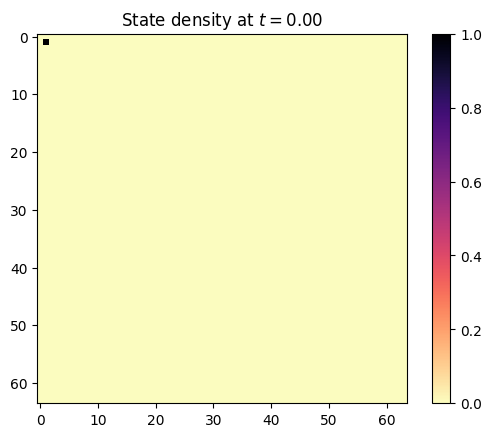

In [8]:
fig, ax = plt.subplots()
image = ax.imshow(np.abs(result.observations[0]), cmap='magma_r', vmin=0, vmax=1)
plt.colorbar(image)

def update(frame):
    ax.set_title(f'State density at $t = {timesteps[frame]:.2f}$')
    image.set_data(np.abs(result.observations[frame]))
    return [image]

ani = animation.FuncAnimation(fig, update, frames=len(result.observations))

from IPython.display import HTML
HTML(ani.to_jshtml())

## Complete Code

```python
# Title    : HQS Quantum Solver Linblad Solver
# Filename : lindblad.py

# ===== Imports =====

import matplotlib.pyplot as plt
import numpy as np
import numpy.random
from matplotlib import animation
from scipy.linalg import toeplitz

from hqs_quantum_solver.spins import (
    VectorSpace, Operator, SpinState, isotropic_interaction)
from hqs_quantum_solver.util import unit_vector
from hqs_quantum_solver.lindblad import Lindbladian
from hqs_quantum_solver.evolution import evolve_krylov, observers

# ===== Parameters =====

n_spins = 6  # The number of spins.
t_end = 10   # The duration of the simulation.
J = 1        # The interaction strength.

# ===== Constructing the Lindbladian =====

v = VectorSpace(sites=n_spins, total_spin_z="all")

coef = J * toeplitz(np.zeros(v.sites), unit_vector(v.sites, 1))
H = Operator(isotropic_interaction(coef), domain=v, dtype=complex)

rng = numpy.random.default_rng(1234)

def random_positive_definite(low, high, shape):
    r = rng.uniform(low, high, shape)
    return r.T.conj() @ r

gamma_z = random_positive_definite(0, 0.3, (v.sites, v.sites))
gamma_p = random_positive_definite(0, 0.2, (v.sites, v.sites))
gamma_m = random_positive_definite(0, 0.1, (v.sites, v.sites))

L = Lindbladian(H, gamma_z, gamma_p, gamma_m)

# ===== Initial State =====

state = v.fock_state([SpinState.UP] + [SpinState.DOWN] * (n_spins-1))
rho = state[:,np.newaxis] @ state[:,np.newaxis].T.conj()

# ===== Time Evolution =====

timesteps = np.linspace(0, t_end)

def progress(t):
    print(f"t = {t:7.2f}", end="\r", flush=True)

result = evolve_krylov(
    L, rho, timesteps, observer=observers.state(), progress=progress)

print()

# ===== Visualization =====

fig, ax = plt.subplots()
image = ax.imshow(np.abs(result.observations[0]), cmap='magma_r', vmin=0, vmax=1)
plt.colorbar(image)

def update(frame):
    ax.set_title(f'State density at $t = {timesteps[frame]:.2f}$')
    image.set_data(np.abs(result.observations[frame]))
    return [image]

ani = animation.FuncAnimation(fig, update, frames=len(result.observations))
plt.show()
```